# Implementing a reparameterized Beta sampler
@fritzo 2017-11-30

This notebook derives a `standard_beta_grad(x,alpha,beta)` function could be used to compute reparameterized gradients in `torch.distributions.Beta().sample()`. This would replace the current stochastic reparameterized gradient estimator based on `Gamma().sample()`.

In [1]:
import torch
from torch.autograd import Variable
import itertools
import numbers
import numpy as np
import scipy.stats
import scipy.optimize
from matplotlib import pyplot
from torch.distributions import Beta, Normal
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

In [2]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

First, let's use SciPy to compute the desired reparameterized gradient for given (x, alpha,beta). This is based on the following definition. Let $x\sim Beta(\alpha,\beta)$ be a Beta random variable. The the reparameterized gradient wrt $\alpha$ is 
$$
 \frac {dx}{d\alpha} = -\frac{\frac d{d\alpha}cdf(x;\alpha)}
                             {\frac d{dx}cdf(x;\alpha)}
                     = -\frac{\frac d{d\alpha}cdf(x;\alpha)}{pdf(x;\alpha)}
$$

In [3]:
def dx_dalpha(x, alpha, beta):
    """
    Computes finite-difference approximation of the reparameterized gradient dx/dalpha.
    """
    cdf = scipy.stats.beta.cdf
    pdf = scipy.stats.beta.pdf
    eps = alpha * 0.04
    d_dalpha = (cdf(x, alpha + eps, beta) - cdf(x, alpha - eps, beta)) / (2 * eps)
    d_dx = pdf(x, alpha, beta)
    return -d_dalpha / d_dx

What this computes is the rate of change in x as alpha is varied and a horizontal line is fixed, cutting through cdf() values:

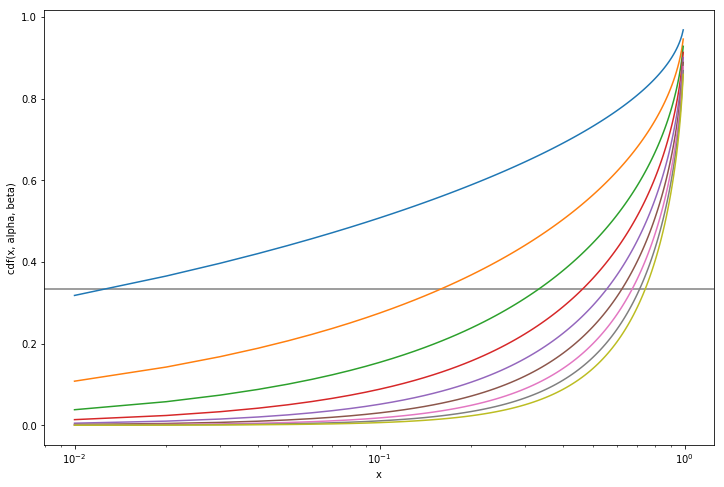

In [4]:
x = np.arange(0, 1, 0.01)
pyplot.figure(figsize=(12,8))
pyplot.axhline(0.333, color='gray')
beta = 0.5
for alpha in np.arange(0.2, 2, 0.2):
    pyplot.plot(x, scipy.stats.beta.cdf(x, alpha, beta))
pyplot.xscale('log')
pyplot.xlabel('x')
pyplot.ylabel('cdf(x, alpha, beta)')
pyplot.show()

In [19]:
def dx_dalpha_small(x, alpha, beta):
    return -x / alpha * (np.log(x) - 1.0 / alpha - scipy.special.digamma(alpha))
def dx_alpha_small_valid(x, alpha, beta):
    return x < 0.001

def dx_dalpha_large(x, alpha, beta):
    return -x / alpha * (np.log(x) - 1.0 / alpha - scipy.special.digamma(alpha))
def dx_alpha_large_valid(x, alpha, beta):
    return x < 0.001

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


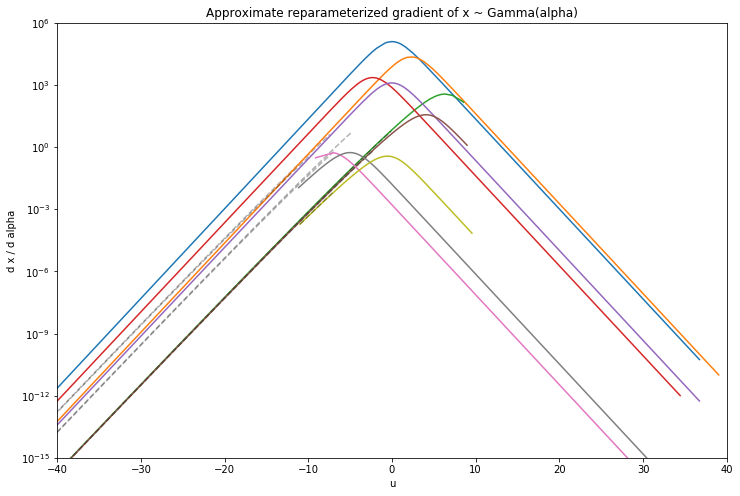

In [20]:
pyplot.figure(figsize=(12, 8))
for alpha, beta in itertools.product([1e-3, 1e-2, 1e0], [1e-3, 1e-2, 1e0]):
    x = scipy.stats.beta.rvs(np.ones(10000) * alpha, np.ones(10000) * beta)
    x.sort()
    u = np.log(x / alpha) - np.log((1 - x) / beta)
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)))
    w = dx_alpha_small_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_small(x[w], alpha, beta), 'k--', alpha=0.3)
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('u')
pyplot.ylabel('d x / d alpha')
pyplot.yscale('log')
pyplot.xlim(-40, 40)
pyplot.ylim(1e-15, 1e6)
pyplot.legend()
pyplot.show()

Jumping ahead, let's see how our approximation works on randomly drawn samples for various `alpha` values between 0.0001 and 10000 (this uses the torch implementation):

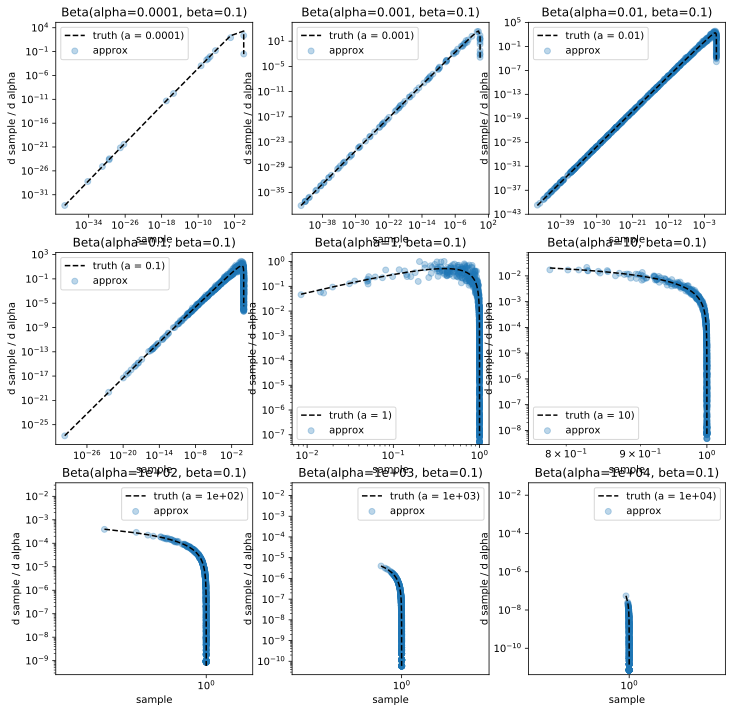

In [612]:
set_seed(0)
alpha = 29
num_samples = 1000
fig, axes = pyplot.subplots(3, 3, figsize=(12,12))
alpha_grid = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
for ax, alpha in zip(axes.reshape(-1), alpha_grid):
    beta = 0.1
    alphas = Variable(alpha * torch.ones(num_samples), requires_grad=True)
    betas = Variable(beta * torch.ones(alphas.size()))
    x = Beta(alphas, betas).sample()
    x.sum().backward()
    x, ind = x.data.sort()
    x = x.numpy()
    actual_grad = alphas.grad.data[ind].numpy()
    alphas = alphas.data[ind].numpy()
    ax.scatter(x, actual_grad, alpha=0.3, label='approx')
    ax.plot(x, dx_dalpha(x, alpha, beta), 'k--', label='truth (a = {:0.2g})'.format(alpha))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Beta(alpha={:0.2g}, beta={:0.2g})'.format(alpha, beta))
    ax.set_xlabel('sample')
    ax.set_ylabel('d sample / d alpha')
    ax.legend()
pyplot.show()

## Benchmarks

And let's see how expensive the approximation is. It's actually cheaper than the forward sampler.

In [8]:
n = 10
dist = Beta(Variable(torch.ones(n, 1000, 1000), requires_grad=True),
            Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.sample()
print('---- Backward ----')
%time x.sum().backward()

---- Forward ----
CPU times: user 1.2 s, sys: 48 ms, total: 1.25 s
Wall time: 1.25 s
---- Backward ----
CPU times: user 948 ms, sys: 133 ms, total: 1.08 s
Wall time: 1.08 s


Here's a Normal distribution for comparison.

In [9]:
n = 10
dist = Normal(Variable(torch.ones(n, 1000, 1000), requires_grad=True),
              Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.sample()
# %time x = dist.sample(requires_grad=True)
# print('---- Backward ----')
# %time x.sum().backward()

---- Forward ----
CPU times: user 360 ms, sys: 27.8 ms, total: 388 ms
Wall time: 387 ms


## Approximating the reparameterized gradient

Now let's derive the approximation. Recall the shape of `cdf(x, alpha, beta)` that we want to approximate.

Let's approximate using a trivariate rational function of $\log(x/\alpha)$ and $\log(\alpha)$.

In [53]:
def expand_all(*args):
    zero = np.zeros(np.broadcast(*args).shape)
    return tuple(zero + arg for arg in args)

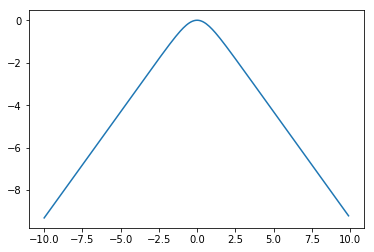

In [250]:
x = np.arange(-10, 10, 0.1)
pyplot.plot(x, -np.cosh(x))

In [660]:
K = 14  # number of training parameters
def dx_dalpha_approx(x, alpha, beta, coeff):
    x, alpha, beta = expand_all(x, alpha, beta)
    u = np.log(x / alpha) - np.log((1.0 - x) / beta)
    a = np.log(alpha)
    b = np.log(beta)
    coeff = list(coeff)
    c = coeff.pop
    u0 = c() + c() * a + c() * b + c() * a * a + c() * a * b + c() * b * b
    # u0 /= 1. + c() * a + c() * b + c() * a * a + c() * a * b + c() * b * b
    u1 = np.maximum(0.0, 1.0 + c())
    g0 = c() + c() * a + c() * b + c() * a * a + c() * a * b + c() * b * b
    # g0 /= 1. + c() * a + c() * b + c() * a * a + c() * a * b + c() * b * b
    g1 = np.maximum(0.0, 1.0 + c())
    assert not coeff, len(coeff)
    return g0 * np.cosh((u - u0) * u1) ** (-g1)

In [661]:
np.random.seed(0)
size_train = 5000
LB, UB = 1e-2, 1e0
alpha_train = np.exp(np.random.random(size_train) * (np.log(UB) - np.log(LB)) + np.log(LB))
beta_train = np.exp(np.random.random(size_train) * (np.log(UB) - np.log(LB)) + np.log(LB))
alpha_train.sort()
x_train = scipy.stats.beta.rvs(alpha_train, beta_train)
grad_train = dx_dalpha(x_train, alpha_train, beta_train)

valid = (grad_train > 1e-20)
alpha_train = alpha_train[valid]
beta_train = beta_train[valid]
x_train = x_train[valid]
grad_train = grad_train[valid]

print('alpha = [{:0.5g}, {:0.5g}, ..., {:0.5g}, {:0.5g}]'.format(
    alpha_train[0], alpha_train[1], alpha_train[-2], alpha_train[-1]))
print('x = [{:0.5g}, {:0.5g}, ..., {:0.5g}, {:0.5g}]'.format(
    x_train[0], x_train[1], x_train[-2], x_train[-1]))
print('grad = [{:0.5g}, {:0.5g}, ..., {:0.5g}, {:0.5g}]'.format(
    grad_train[0], grad_train[1], grad_train[-2], grad_train[-1]))
print(len(grad_train))

alpha = [0.010003, 0.010003, ..., 0.99968, 0.99983]
x = [0.93461, 1.566e-05, ..., 1, 0.9959]
grad = [95.722, 0.048928, ..., 5.5208e-07, 0.0052185]
3908


In [662]:
def approx_objective(coeff):
    approx = dx_dalpha_approx(x_train, alpha_train, beta_train, coeff).reshape(-1)
    return 1 - approx / grad_train

In [663]:
coeff0 = np.zeros(K)
coeff = coeff0

In [664]:
soln = scipy.optimize.least_squares(approx_objective, coeff0,
                                    xtol=1e-20, ftol=1e-20, gtol=1e-20)
coeff = soln.x
print(soln)
print('coeff = {}'.format(list(coeff)))
error = approx_objective(coeff)
print('error = {:0.3g} rms, {:0.3g} max'.format(
    (error ** 2).mean() ** 0.5, np.abs(error).max()))

 active_mask: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
        cost: 283.78426362357197
         fun: array([ 0.97780663,  0.14842402, -0.1757007 , ...,  0.05871733,
       -0.85154202, -0.49732567])
        grad: array([ -4.45949624e-07,   6.31337350e-07,   5.91121264e-07,
         8.83927846e-08,  -7.93336401e-08,  -5.40111452e-07,
         3.76969847e-07,   5.07781215e-06,   8.45071058e-06,
        -2.73505657e-06,   1.19944375e-06,  -1.33244360e-06,
         3.12196205e-07,   3.77163685e-06])
         jac: array([[  2.22252733e-02,  -5.43490797e-03,  -8.58235359e-03, ...,
          5.85072423e-02,   9.23897407e-02,  -2.00636279e-02],
       [  2.05735085e+00,  -2.52807841e-01,  -3.59905921e-01, ...,
         -2.66664675e+00,  -3.79632933e+00,   8.24423345e-01],
       [  1.96300807e+01,  -3.00383538e-01,  -4.63679224e-01, ...,
         -3.40744219e+00,  -5.25981027e+00,   1.14277692e+00],
       ..., 
       [  3.90821207e-01,  -5.72723518e+00, 

Here's a per-region version that's closer our C implementation:

In [665]:
def dx_dalpha_final(x, alpha, beta):
    return dx_dalpha_approx(x, alpha, beta, coeff)

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


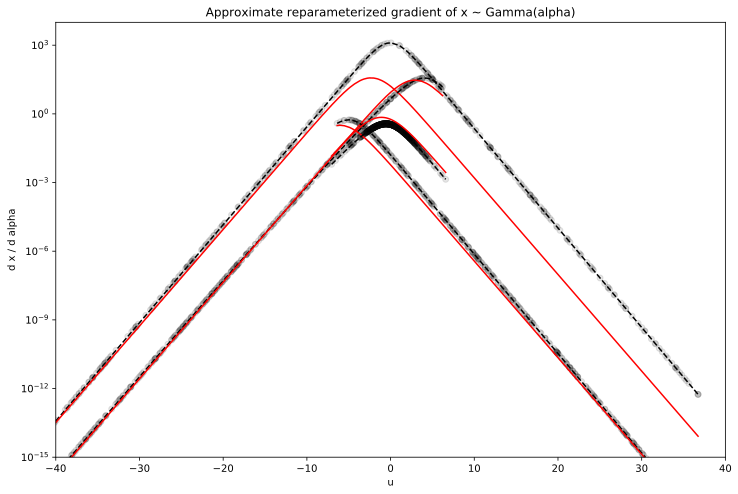

In [666]:
pyplot.figure(figsize=(12, 8))
for alpha, beta in itertools.product([1e-2, 1e0], [1e-2, 1e0]):
    x = scipy.stats.beta.rvs(np.ones(1000) * alpha, np.ones(1000) * beta)
    x.sort()
    u = np.log(x / alpha) - np.log((1 - x) / beta)
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)), 'k--')
    pyplot.scatter(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)), color='black', alpha=0.1)
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha_final(x, alpha, beta)), 'r-')
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('u')
pyplot.ylabel('d x / d alpha')
pyplot.yscale('log')
pyplot.xlim(-40, 40)
pyplot.ylim(1e-15, 1e4)
pyplot.legend()
pyplot.show()

Finally, let's print out C code for the coefficients and embed this directly in `aten/src/TH/THRandom.c`.

In [461]:
print('static const double coef_uv[3][8] = {')
for row in coeff.reshape(3, 8):
    print('  {' + ', '.join(map('{:0.8g}'.format, row)) +'},')
print('};')

static const double coef_uv[3][8] = {


ValueError: cannot reshape array of size 14 into shape (3,8)